In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from ctgan import CTGAN

# Chargement
df = pd.read_csv(r"C:\Users\Hp\Desktop\2025 - Reda Fritet - RAUC\archive (2)\healthcare-dataset-stroke-data.csv")
df.drop(columns=["id"], inplace=True)

# Encodage des colonnes catégorielles
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

# Imputation + Normalisation
df["bmi"] = SimpleImputer(strategy="mean").fit_transform(df[["bmi"]])
scaler = StandardScaler()
df[["age", "avg_glucose_level", "bmi"]] = scaler.fit_transform(df[["age", "avg_glucose_level", "bmi"]])

# CTGAN sur la classe minoritaire
df_minority = df[df["stroke"] == 1]
ctgan = CTGAN(epochs=300)
ctgan.fit(df_minority, discrete_columns=categorical_cols)
new_data = ctgan.sample(1000)
new_data["stroke"] = 1

# Fusion avec les données originales
df_full = pd.concat([df, new_data], ignore_index=True)


In [2]:
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from sklearn.utils import shuffle

X = df_full.drop("stroke", axis=1)
y = df_full["stroke"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

# Parfait équilibrage manuel
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name="stroke")], axis=1)
df_pos = df_resampled[df_resampled["stroke"] == 1]
df_neg = df_resampled[df_resampled["stroke"] == 0]
min_len = min(len(df_pos), len(df_neg))

df_balanced = pd.concat([df_pos.sample(min_len, random_state=42), df_neg.sample(min_len, random_state=42)], ignore_index=True)
df_balanced = shuffle(df_balanced, random_state=42)
X_resampled = df_balanced.drop("stroke", axis=1)
y_resampled = df_balanced["stroke"]


In [3]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

xgb = XGBClassifier(learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8, 
                    use_label_encoder=False, eval_metric='logloss', random_state=42)
lgbm = LGBMClassifier(learning_rate=0.05, n_estimators=500, max_depth=7, 
                      class_weight='balanced', random_state=42)
rf = RandomForestClassifier(n_estimators=300, max_depth=12, 
                            class_weight='balanced', random_state=42)

xgb.fit(X_resampled, y_resampled)
lgbm.fit(X_resampled, y_resampled)
rf.fit(X_resampled, y_resampled)


D:\anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:47:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 2755, number of negative: 2755
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 5510, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=300,
                       random_state=42)

In [4]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

xgb = XGBClassifier(learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8, 
                    use_label_encoder=False, eval_metric='logloss', random_state=42)
lgbm = LGBMClassifier(learning_rate=0.05, n_estimators=500, max_depth=7, 
                      class_weight='balanced', random_state=42)
rf = RandomForestClassifier(n_estimators=300, max_depth=12, 
                            class_weight='balanced', random_state=42)

xgb.fit(X_resampled, y_resampled)
lgbm.fit(X_resampled, y_resampled)
rf.fit(X_resampled, y_resampled)


D:\anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:47:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 2755, number of negative: 2755
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 5510, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=300,
                       random_state=42)


XGBoost - Seuil optimal : 0.75
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       972
           1       0.62      0.80      0.70       250

    accuracy                           0.86      1222
   macro avg       0.78      0.84      0.80      1222
weighted avg       0.88      0.86      0.87      1222


LightGBM - Seuil optimal : 0.75
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       972
           1       0.67      0.83      0.74       250

    accuracy                           0.88      1222
   macro avg       0.81      0.86      0.83      1222
weighted avg       0.90      0.88      0.89      1222


Random Forest - Seuil optimal : 0.70
              precision    recall  f1-score   support

           0       0.93      0.88      0.91       972
           1       0.63      0.76      0.68       250

    accuracy                           0.86      1222
   macro avg       0.78  

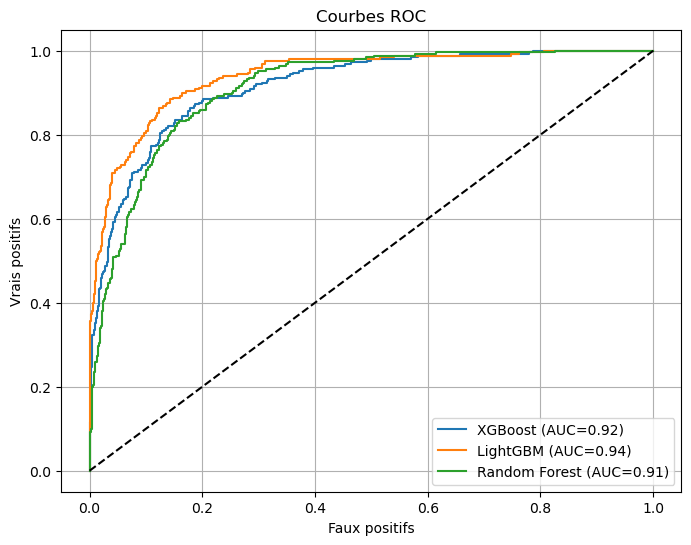

In [5]:
from sklearn.metrics import classification_report, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

def find_best_threshold(model, X, y_true):
    y_proba = model.predict_proba(X)[:, 1]
    thresholds = np.arange(0.1, 0.9, 0.05)
    f1s = [f1_score(y_true, (y_proba >= t).astype(int)) for t in thresholds]
    best_t = thresholds[np.argmax(f1s)]
    return best_t, max(f1s)

best_xgb_t, _ = find_best_threshold(xgb, X_test, y_test)
best_lgb_t, _ = find_best_threshold(lgbm, X_test, y_test)
best_rf_t, _ = find_best_threshold(rf, X_test, y_test)

plt.figure(figsize=(8, 6))
for model, name, t in zip([xgb, lgbm, rf], ["XGBoost", "LightGBM", "Random Forest"], 
                          [best_xgb_t, best_lgb_t, best_rf_t]):
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= t).astype(int)
    print(f"\n{name} - Seuil optimal : {t:.2f}")
    print(classification_report(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("Courbes ROC")
plt.xlabel("Faux positifs")
plt.ylabel("Vrais positifs")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
import joblib

joblib.dump(xgb, "xgboost_final_ctgan.pkl")
joblib.dump(lgbm, "lightgbm_final_ctgan.pkl")
joblib.dump(rf, "randomforest_final_ctgan.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(encoders, "encoders.pkl")

print("Modèles et outils sauvegardés avec succès.")


Modèles et outils sauvegardés avec succès.


In [7]:
import itertools

# Valeurs manuelles possibles pour chaque variable
values_dict = {
    "gender": ["Male", "Female"],
    "age": [40, 60],
    "hypertension": [0, 1],
    "heart_disease": [0, 1],
    "ever_married": ["Yes", "No"],
    "work_type": ["Private", "Self-employed", "Govt_job"],
    "Residence_type": ["Urban", "Rural"],
    "avg_glucose_level": [80.0, 120.0],
    "bmi": [22.0, 30.0],
    "smoking_status": ["never smoked", "formerly smoked", "smokes"]
}

# Générer toutes les combinaisons
columns = list(values_dict.keys())
all_combinations = list(itertools.product(*values_dict.values()))
df_all_cases = pd.DataFrame(all_combinations, columns=columns)

# Encodage
for col in categorical_cols:
    df_all_cases[col] = encoders[col].transform(df_all_cases[col].astype(str))

# Normalisation
df_all_cases[["age", "avg_glucose_level", "bmi"]] = scaler.transform(df_all_cases[["age", "avg_glucose_level", "bmi"]])

# Prédiction
model = joblib.load("randomforest_final_ctgan.pkl")  # ou lgbm, xgb
df_all_cases["stroke_pred"] = model.predict(df_all_cases)

# Affichage des cas à risque
df_risk = df_all_cases[df_all_cases["stroke_pred"] == 1]
print(f"{len(df_risk)} cas sur {len(df_all_cases)} prédisent un AVC.")
print(df_risk)

841 cas sur 2304 prédisent un AVC.
      gender       age  hypertension  heart_disease  ever_married  work_type  \
289        1 -0.142705             1              0             1          2   
294        1 -0.142705             1              0             1          2   
295        1 -0.142705             1              0             1          2   
296        1 -0.142705             1              0             1          2   
301        1 -0.142705             1              0             1          2   
...      ...       ...           ...            ...           ...        ...   
2299       0  0.741843             1              1             0          0   
2300       0  0.741843             1              1             0          0   
2301       0  0.741843             1              1             0          0   
2302       0  0.741843             1              1             0          0   
2303       0  0.741843             1              1             0          0   

    